In [1]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
sns.set(style="ticks")
%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

sns.set_context('poster')
# import matplotlib.pylab as pylab
# params = {'legend.fontsize': 'large',
#           'figure.figsize': (15, 5),
#          'axes.labelsize': 'large',
#          'axes.titlesize':'large',
#          'xtick.labelsize':'large',
#          'ytick.labelsize':'large'}
# pylab.rcParams.update(params)}

In [2]:
data = pd.read_csv("HK/listings.csv")

**First, conduct a quick overview on the data**

In [3]:
# output the basic info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12569 entries, 0 to 12568
Data columns (total 16 columns):
id                                12569 non-null int64
name                              12560 non-null object
host_id                           12569 non-null int64
host_name                         12568 non-null object
neighbourhood_group               0 non-null float64
neighbourhood                     12569 non-null object
latitude                          12569 non-null float64
longitude                         12569 non-null float64
room_type                         12569 non-null object
price                             12569 non-null int64
minimum_nights                    12569 non-null int64
number_of_reviews                 12569 non-null int64
last_review                       8855 non-null object
reviews_per_month                 8855 non-null float64
calculated_host_listings_count    12569 non-null int64
availability_365                  12569 non-null int64
dtyp

In [4]:
# look the missing values
data.isnull().sum()
# looks pretty good

id                                    0
name                                  9
host_id                               0
host_name                             1
neighbourhood_group               12569
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                        3714
reviews_per_month                  3714
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [5]:
(data['last_review'].isnull()==data['reviews_per_month'].isnull()).all()

True

In [6]:
data = data.drop(['neighbourhood_group','last_review', 'reviews_per_month'], axis=1)

In [7]:
data = data.drop(['host_name'], axis=1)

In [8]:
data = data.drop(['name'], axis=1)

In [9]:
data.isnull().sum()

id                                0
host_id                           0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [10]:
# check numeric variables 
data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
count,1.256900e+04,1.256900e+04,12569.000000,12569.000000,12569.000000,12569.000000,12569.000000,12569.000000,12569.000000
mean,2.321987e+07,8.482471e+07,22.304671,114.159823,802.773013,7.731880,20.885910,34.330575,158.277906
std,1.010947e+07,8.003232e+07,0.049794,0.045511,1874.064516,28.636382,42.811686,96.904196,143.216745
min,6.907400e+04,5.556000e+03,22.158560,113.856700,0.000000,1.000000,0.000000,1.000000,0.000000
25%,1.610194e+07,1.723227e+07,22.281850,114.151690,352.000000,1.000000,0.000000,1.000000,11.000000
50%,2.464426e+07,5.175132e+07,22.296440,114.170670,516.000000,2.000000,4.000000,4.000000,110.000000
75%,3.239012e+07,1.386492e+08,22.313320,114.176450,876.000000,4.000000,20.000000,15.000000,329.000000
max,3.666248e+07,2.752271e+08,22.563080,114.361730,78228.000000,1100.000000,626.000000,484.000000,365.000000


The mean latitude: 22.304671 
<br>
The mean longitude: 114.159823
<br>
Which can be assumed as "Central Point"

Remove the records with unrealistic data

In [11]:
# clean the data with price = 0
# clean the data with minimun_night greater than 100
data = data[data.price != 0]
data = data[data.minimum_nights <= 100]

data.head()

**Finding out the first 3 districts with most listing numbers** 

In [12]:
data.pivot_table(index='neighbourhood',columns='room_type',values='price',aggfunc='mean')

room_type,Entire home/apt,Private room,Shared room
neighbourhood,,,
Central & Western,966.526232,513.379104,448.046875
Eastern,963.087912,418.305000,269.400000
Islands,892.474164,589.910995,152.000000
Kowloon City,1011.807292,881.382979,568.250000
Kwai Tsing,1146.913043,970.714286,649.000000
Kwun Tong,1396.920000,433.370370,214.333333
North,698.668874,371.700000,229.684211
Sai Kung,1408.254237,471.820000,534.400000
Sha Tin,836.931818,405.786885,1491.375000


# Group Exploration for the distribution as well as price in each district

In [13]:
import folium as fl
from folium import plugins
from folium.plugins import HeatMap

In [14]:
hk_map = fl.Map(location=[22.38,114.13],zoom_start = 10)
data_loc = data[['latitude','longitude']].values
HeatMap(data = data_loc.tolist(), radius=8, max_zoom=10).add_to(hk_map)
hk_map

In [15]:
data_loc

array([[ 22.28352, 114.15018],
       [ 22.20022, 114.13461],
       [ 22.28407, 114.1557 ],
       ...,
       [ 22.32047, 114.17179],
       [ 22.53295, 114.08647],
       [ 22.27922, 114.22549]])

In [16]:
import geopandas as gpd
import descartes
from descartes.patch import PolygonPatch

In [17]:
# Importing the Hong Kong 18 districts boundary GeoJSON file
map_data = gpd.read_file("HK/Hong_Kong_18_Districts/Hong_Kong_18_Districts.shp")

In [18]:
# Uppercase all districts' name to match the HK's shapefile
data["neighbourhood"] = data['neighbourhood'].str.upper()

In [19]:
# Dropping the empty column
map_data.drop("TCNAME", axis = 1, inplace = True)
# Creating a dataframe of listing counts and median price by borough
neighbour_price = pd.DataFrame(data.groupby('neighbourhood').size())

In [20]:
neighbour_price.rename(columns={0: 'number_of_listings'}, inplace=True)
neighbour_price['median_price'] = data.groupby('neighbourhood').price.median().values
neighbour_price['mean_price'] = data.groupby('neighbourhood').price.mean().values
# Joining the dataframes
neighbour_map_data = map_data.set_index('ENAME').join(neighbour_price)

In [21]:
neighbour_map_data.head()

,OBJECTID,Shape__Are,Shape__Len,geometry,number_of_listings,median_price,mean_price
ENAME,,,,,,,
WONG TAI SIN,1,1.092784e+07,17995.640782,"POLYGON ((114.17942 22.34905, 114.17946 22.349...",25,360.0,484.480000
KWAI TSING,2,2.774914e+07,56392.256966,"MULTIPOLYGON (((114.11265 22.36046, 114.11283 ...",38,688.0,1068.894737
SHAM SHUI PO,3,1.116098e+07,29302.817383,"POLYGON ((114.14684 22.34417, 114.14796 22.345...",252,352.0,476.230159
YAU TSIM MONG,4,8.135366e+06,22711.608635,"MULTIPOLYGON (((114.15306 22.32312, 114.15309 ...",4751,462.0,765.349611
KOWLOON CITY,5,1.184285e+07,31834.417414,"MULTIPOLYGON (((114.19659 22.31134, 114.19657 ...",463,399.0,911.120950


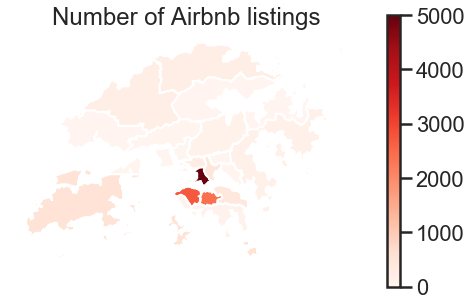

In [22]:
# Plotting the number of listings in each district
fig1, ax1 = plt.subplots(1, 1, figsize=(8,5))
neighbour_map_data.plot(column='number_of_listings', cmap='Reds', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings')
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=5000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()
# fig1.savefig('Number.png')

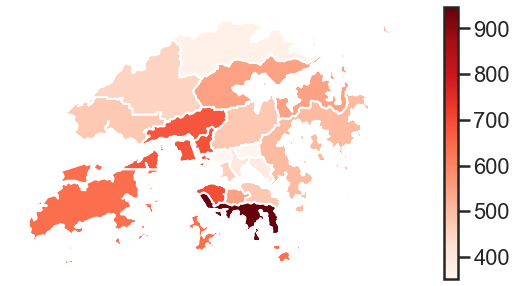

In [23]:
# Plotting the median price in each district
fig2, ax2 = plt.subplots(1, figsize=(12,5))
neighbour_map_data.plot(column='median_price', cmap='Reds', ax=ax2)
ax2.axis('off')
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=neighbour_map_data.median_price.min(), vmax=neighbour_map_data.median_price.max()))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

In [24]:
top3 = data.groupby("neighbourhood").price.count().sort_values(ascending=False).head(3).index

In [25]:
top3 = top3.tolist()

In [26]:
top3 = neighbour_map_data.loc[top3]

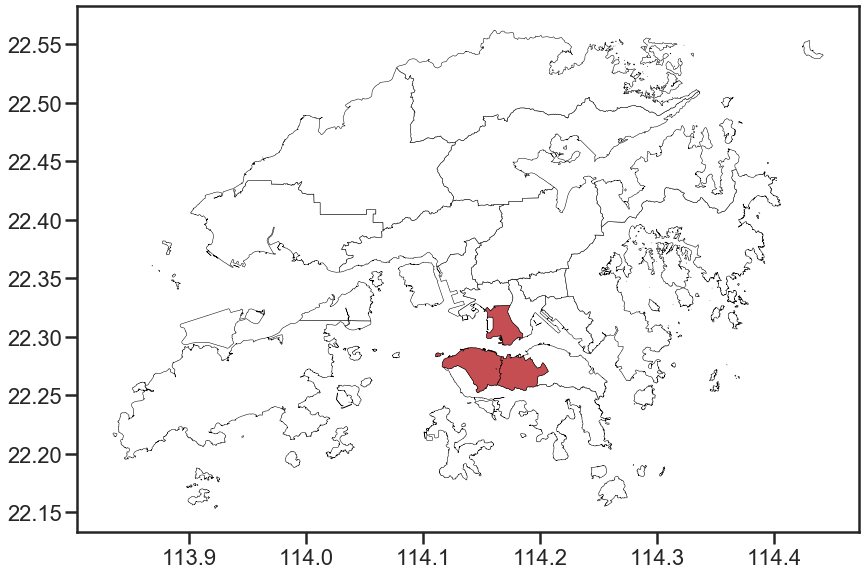

In [27]:
base = neighbour_map_data.plot(figsize=(14, 12), color = 'white', edgecolor='black', linewidth = 0.5)
top3.plot(ax = base, color='r', edgecolor='black', linewidth = 0.5 )

Export the top3 data as shapefile format file

In [28]:
top3.to_file('HK/top3/top3.shp')

In [29]:
top3

,OBJECTID,Shape__Are,Shape__Len,geometry,number_of_listings,median_price,mean_price
ENAME,,,,,,,
YAU TSIM MONG,4,8.135366e+06,22711.608635,"MULTIPOLYGON (((114.15306 22.32312, 114.15309 ...",4751,462.0,765.349611
CENTRAL & WESTERN,11,1.460474e+07,26681.287969,"MULTIPOLYGON (((114.11701 22.28472, 114.11696 ...",2621,696.0,838.028997
WAN CHAI,12,1.161490e+07,19548.075298,"MULTIPOLYGON (((114.20012 22.27387, 114.20047 ...",2300,548.0,824.892609


In [46]:
top3["geometry"]

ENAME
YAU TSIM MONG        MULTIPOLYGON (((114.15306 22.32312, 114.15309 ...
CENTRAL & WESTERN    MULTIPOLYGON (((114.11701 22.28472, 114.11696 ...
WAN CHAI             MULTIPOLYGON (((114.20012 22.27387, 114.20047 ...
Name: geometry, dtype: geometry

In [30]:
top3["center"] = top3["geometry"].centroid
top3_points = top3.copy()
top3_points.set_geometry("center", inplace = True)

In [45]:
top3_points

,OBJECTID,Shape__Are,Shape__Len,geometry,number_of_listings,median_price,mean_price,center
ENAME,,,,,,,,
YAU TSIM MONG,4,8.135366e+06,22711.608635,"MULTIPOLYGON (((114.15306 22.32312, 114.15309 ...",4751,462.0,765.349611,POINT (114.16852 22.30968)
CENTRAL & WESTERN,11,1.460474e+07,26681.287969,"MULTIPOLYGON (((114.11701 22.28472, 114.11696 ...",2621,696.0,838.028997,POINT (114.14643 22.27499)
WAN CHAI,12,1.161490e+07,19548.075298,"MULTIPOLYGON (((114.20012 22.27387, 114.20047 ...",2300,548.0,824.892609,POINT (114.18267 22.26888)


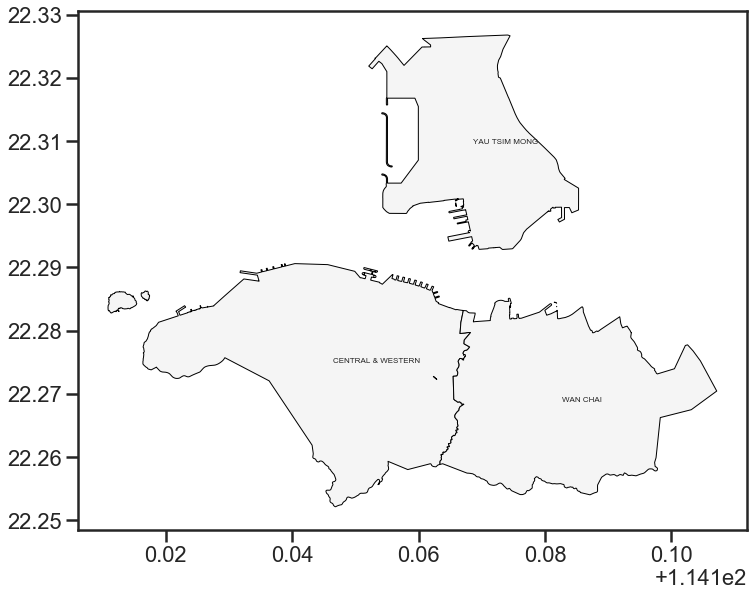

In [31]:
map_top3 = top3.plot(figsize=(12,10), color = 'whitesmoke', edgecolor='black', linewidth = 1, legend = True)
texts = []

for x, y, label in zip(top3_points.geometry.x, top3_points.geometry.y, top3_points.index):
    texts.append(plt.text(x, y, label, fontsize = 8))


In [32]:
data.head()

,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,69074,160139,CENTRAL & WESTERN,22.28352,114.15018,Entire home/apt,1408,3,130,1,159
1,101765,532909,ISLANDS,22.20022,114.13461,Entire home/apt,430,2,11,1,47
2,103760,304876,CENTRAL & WESTERN,22.28407,114.15570,Entire home/apt,853,2,260,12,329
3,132773,304876,CENTRAL & WESTERN,22.28868,114.14494,Entire home/apt,1056,2,259,12,308
4,133390,654642,CENTRAL & WESTERN,22.28343,114.15539,Entire home/apt,939,2,27,1,91


In [33]:
top3.index

Index(['YAU TSIM MONG', 'CENTRAL & WESTERN', 'WAN CHAI'], dtype='object', name='ENAME')

In [34]:
set(data.neighbourhood)

{'CENTRAL & WESTERN',
 'EASTERN',
 'ISLANDS',
 'KOWLOON CITY',
 'KWAI TSING',
 'KWUN TONG',
 'NORTH',
 'SAI KUNG',
 'SHA TIN',
 'SHAM SHUI PO',
 'SOUTHERN',
 'TAI PO',
 'TSUEN WAN',
 'TUEN MUN',
 'WAN CHAI',
 'WONG TAI SIN',
 'YAU TSIM MONG',
 'YUEN LONG'}

In [35]:
top3_data = data[(data.neighbourhood == 'YAU TSIM MONG') | (data.neighbourhood == 'CENTRAL & WESTERN') | (data.neighbourhood == 'WAN CHAI')]

In [36]:
top3_data.shape

(9672, 11)

In [37]:
top3_data.groupby('neighbourhood').latitude.mean()

neighbourhood
CENTRAL & WESTERN    22.284190
WAN CHAI             22.275148
YAU TSIM MONG        22.308009
Name: latitude, dtype: float64

In [38]:
top3_data.groupby('neighbourhood').longitude.mean()

neighbourhood
CENTRAL & WESTERN    114.146482
WAN CHAI             114.182058
YAU TSIM MONG        114.171048
Name: longitude, dtype: float64

In [39]:
top3_data['cen_lat'] = 0
top3_data['cen_long'] = 0

C:\Users\Martin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Martin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [40]:
top3_data.loc[top3_data.neighbourhood == 'CENTRAL & WESTERN', 'cen_lat'] = top3_data.groupby('neighbourhood').latitude.mean()[0]
top3_data.loc[top3_data.neighbourhood == 'CENTRAL & WESTERN', 'cen_long'] = top3_data.groupby('neighbourhood').longitude.mean()[0]
top3_data.loc[top3_data.neighbourhood == 'WAN CHAI', 'cen_lat'] = top3_data.groupby('neighbourhood').latitude.mean()[1]
top3_data.loc[top3_data.neighbourhood == 'WAN CHAI', 'cen_long'] = top3_data.groupby('neighbourhood').longitude.mean()[1]
top3_data.loc[top3_data.neighbourhood == 'YAU TSIM MONG', 'cen_lat'] = top3_data.groupby('neighbourhood').latitude.mean()[2]
top3_data.loc[top3_data.neighbourhood == 'YAU TSIM MONG', 'cen_long'] = top3_data.groupby('neighbourhood').longitude.mean()[2]

C:\Users\Martin\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [41]:
from numpy import cos, sin, arcsin, sqrt
from math import radians
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a)) 
    km = 6367 * c
    return km


In [42]:
top3_data.head()

,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,cen_lat,cen_long
0,69074,160139,CENTRAL & WESTERN,22.28352,114.15018,Entire home/apt,1408,3,130,1,159,22.28419,114.146482
2,103760,304876,CENTRAL & WESTERN,22.28407,114.15570,Entire home/apt,853,2,260,12,329,22.28419,114.146482
3,132773,304876,CENTRAL & WESTERN,22.28868,114.14494,Entire home/apt,1056,2,259,12,308,22.28419,114.146482
4,133390,654642,CENTRAL & WESTERN,22.28343,114.15539,Entire home/apt,939,2,27,1,91,22.28419,114.146482
5,163214,767910,CENTRAL & WESTERN,22.28494,114.15251,Entire home/apt,1048,5,0,1,83,22.28419,114.146482


In [43]:
top3_data['distance'] = top3_data.apply(lambda top3_data: haversine(top3_data.longitude,top3_data.latitude, top3_data.cen_long,top3_data.cen_lat), axis =1)

C:\Users\Martin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [44]:
# top3_data.to_csv('HK/top3_dist.csv')